# Symbolic regression with GP

## Imports

In [479]:
import numpy as np
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Union
import matplotlib.pyplot as plt
from copy import deepcopy
import random
import networkx as nx
from sklearn.model_selection import train_test_split, KFold
from enum import Enum
from statistics import mean

## Colab setup (only if needed)

In [480]:
# from google.colab import drive
# drive.mount("/content/drive")
#!unzip /content/drive/MyDrive/CI_shared/data.zip

## Foundation classes

### OperatorCollection
A simple collection of operators, either in NumPy or native Python.

In [481]:
class OperatorCollection:

    def add(x, y):
        return x + y

    def sub(x, y):
        return x - y

    def mul(x, y):
        return x * y

    def neg(x):
        return -x

    def abs(x):
        return np.abs(x)

    def sin(x):
        return np.sin(x)

    def cos(x):
        return np.cos(x)
    
    def exp(x):
        return np.exp(x)
    
    def cosh(x):
        return np.cosh(x)
    
    def sinh(x):
        return np.sinh(x)


### Operator
A class to handle operators and their characteristics.

In [482]:
class Operator:
    def __init__(self, symbol, function, in_params):
        self.symbol = symbol
        self.function = function
        self.arity = in_params

    def __call__(self, *args):
        return self.function(*args)

    def __str__(self):
        return self.symbol

    def __repr__(self):
        return self.symbol

### Tree
A class to handle the genome of individuals: each node is considered a tree itself.

In [483]:
class Tree:
    def __init__(
        self,
        max_depth: int = None,
        operators: list[Operator] = None,
        variables: list[str] = None,
        constants_bounds: tuple[float, float] = None,
        min_constants_size: int = 1000
    ):
        """Initialize a tree with a maximum depth, a list of operators, a list of variables, and bounds for the constants.
        
        Args:
            max_depth (int): maximum depth of the tree (at creation)
            operators (list[Operator]): list of operators
            variables (list[str]): list of variables
            constants_bounds (tuple[float, float]): bounds for the constants pool
            min_constants_size (int): minimum size for the constants pool
        """
        self.max_depth = max_depth
        self.operators: list[Operator] = operators
        self.variables = variables
        self.constants_bounds = constants_bounds
        self.root = None
        self.children = []
        self.constants_size = max(min_constants_size * int(constants_bounds[1] - constants_bounds[0]), min_constants_size)
        self.depth = 0
        self.len = 0

    @property
    def is_leaf(self):
        return not self.children
    
    @property
    def get_depth(self):
        return self.depth
    
    def __len__(self):
        return self.len

    def _select_constants(self, size: int) -> list[float]:
        constants = np.linspace(*self.constants_bounds, self.constants_size)
        selected_constants = random.choices(constants, k=size)
        return selected_constants

    def _create_random_subtree(self, depth: int) -> tuple["Tree", Union[str, Operator]]:
        
        # Leaf node (variable or constant)
        if depth >= self.max_depth or random.random() < depth / self.max_depth:
            subtree = Tree(self.max_depth, self.operators, self.variables, self.constants_bounds, self.constants_size)
            selected_constants = self._select_constants(len(self.variables) * 3)
            chosen_value = random.choice(self.variables + selected_constants)
            
            # Return tree structure and root content
            return subtree, chosen_value
            
        # Choose operator and create tree
        operator: Operator = random.choice(self.operators)
        num_params = operator.arity
        tree = Tree(self.max_depth, self.operators, self.variables, self.constants_bounds, self.constants_size)
        tree.root = operator
        
        # Recursively create children
        for _ in range(num_params):
            child, child_value = self._create_random_subtree(depth + 1)
            child.root = child_value
            tree.children.append(child)

            assert child.root is not None, f"Expected non-empty root, found {child.root}"

        # Return tree structure and root content
        return tree, operator

    # Implement point mutation
    def _mutate_point(self) -> "Tree":
        """Mutate a random node in the tree with a randomly generated node.
        
        Returns:
            Tree: a mutated tree
        """
        
        # Randomly choose a node
        nodes = self._get_all_nodes()
        node, _ = random.choice(nodes)
        
        # Mutate node
        if not node.children:
            # Leaf node
            if random.random() < 0.5:
                
                # 80% variable or constant node
                selected_constants = self._select_constants(len(self.variables) * 3)
                node.root = random.choice(self.variables + selected_constants)
            else:
                # 20% only constant node
                node.root = random.choice(self.constants_bounds)
        else:
            # Operator node: preserve arity in mutation
            node.root = random.choice([operator for operator in self.operators if operator.arity == node.root.arity])

        return node

    # Implement subtree mutation
    def _mutate_subtree(self):
        """Mutate a random subtree with another randomly generated subtree."""

        # Choose a random node that is not a leaf
        nodes = self._get_all_nodes()
        leaves = self._get_all_leaves()
        not_leaves = [node for node in nodes if node[0] not in leaves]

        subtree, current_depth = random.choice(not_leaves)
        num_children = len(subtree.children)

        assert num_children > 0, f"Expected at least one child, found {num_children}"
        
        # Create a new subtree and replace the old one
        pos = random.randint(0, num_children-1)
        child, child_value = self._create_random_subtree(current_depth+1)

        child.root = child_value
        subtree.children[pos] = child
        
    # Get all nodes in the tree
    def _get_all_nodes(self) -> list[tuple["Tree", int]]:
        """Helper method to get all nodes in the tree.
        
        Returns:
            list[tuple[Tree, int]]: list of tuples containing the node and its depth (0 for root)
        """
        nodes = []
        stack = [(self, 0)]

        while stack:
            
            # Pop the node and its depth
            node, depth = stack.pop()
            
            # Append the node and its depth to the list
            nodes.append((node, depth))
            
            # Add children to the stack
            children = list(zip(node.children, [depth + 1] * len(node.children)))
            stack.extend(children)

        return nodes

    # Get all leaves in the tree
    def _get_all_leaves(self) -> list["Tree"]:
        """Helper method to get all leaves in the tree.
        
        Returns:
            list[Tree]: list of leaf nodes
        """
        leaves = []

        # Traverse the tree in post-order
        def traverse(node):
            
            # Leaf reached
            if not node.children:
                leaves.append(node)
                
            # Recursively traverse children
            for child in node.children:
                traverse(child)

        traverse(self)
        return leaves
    
    # Evaluate the tree for a given input dataset
    def _evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluate the tree for a given input.
        
        Args:
            X (np.ndarray): the input data
        
        Returns:
            np.ndarray: the output of the tree
        """
        
        # Recursively evaluate the tree for a given data point
        def evaluate_node(node, x):
            
            # Leaf node
            if not node.children:
                # Variable node
                if node.root in self.variables:
                    return x[self.variables.index(node.root)]
                return node.root
            
            # Operator node: recursively evaluate children
            params = [evaluate_node(child, x) for child in node.children]
            return node.root(*params)

        return np.array([evaluate_node(self, row) for row in X.T])
        
    # Create a new individual
    @staticmethod
    def create_individual(operators: list[Operator], variables: list[str], constants_bounds: tuple[float, float], max_depth: int) -> "Tree":
        """Create a random individual (tree) with a maximum depth
        
        Args:
            operators (list[Operator]): list of operators
            variables (list[str]): list of variables
            constants_bounds (tuple[float, float]): bounds for the constants
            max_depth (int): maximum depth of the tree
            
        Returns:
            Tree: a random tree
        """
        
        tree = Tree(max_depth, operators, variables, constants_bounds)
        tree, _ = tree._create_random_subtree(0)
        tree.depth = max([x[1] for x in tree._get_all_nodes()])
        tree.len = len(tree._get_all_nodes())
        return tree

    @staticmethod
    def mutate(tree: "Tree") -> "Tree":
        """Perform a random mutation on the tree with a given probability.
        
        Args:
            tree (Tree): the tree to mutate
            
        Returns:
            Tree: the mutated tree
        """
        new_tree: Tree = deepcopy(tree)
        mutation = random.choice([
            new_tree._mutate_point,
            new_tree._mutate_subtree
        ])

        mutation()
        
        new_tree.depth = max([x[1] for x in new_tree._get_all_nodes()])
        new_tree.len = len(new_tree._get_all_nodes())

        return new_tree

    @staticmethod
    def crossover(tree1: "Tree", tree2: "Tree") -> "Tree":
        """Perform crossover between two trees by exchanging a random subtree from tree1 with a subtree from tree2.
        
        Args:
            tree1 (Tree): the first tree
            tree2 (Tree): the second tree
            
        Returns:
            Tree: the new tree after crossover
        """
        
        # Deep copy the first tree
        new_tree = deepcopy(tree1)
        
        # Choose a random subtree from each tree
        nodes_tree1 = new_tree._get_all_nodes()
        nodes_tree2 = tree2._get_all_nodes()

        # Perform crossover if both trees have more than one node
        if len(nodes_tree1) > 1 and len(nodes_tree2) > 1:
            
            subtree1, _ = random.choice(nodes_tree1[1:])
            subtree2, _ = random.choice(nodes_tree2[1:])
            
            subtree1.root = subtree2.root
            subtree1.children = deepcopy(subtree2.children)
            
        # Update depth and length of the new tree
        new_tree.depth = max([x[1] for x in new_tree._get_all_nodes()])
        new_tree.len = len(new_tree._get_all_nodes())

        return new_tree

    @staticmethod
    def merge(tree_list: list["Tree"]) -> "Tree":
        """Merge a list of trees into a single tree by summing the outputs of the trees.
        
        Args:
            tree_list (list[Tree]): list of trees to merge
            
        Returns:
            Tree: the merged tree
        """
        
        # Define a generalized sum operator (with undefined arity)
        def generalized_sum(*operands):
            assert len(operands) > 1, f"Expected at least 2 operands, found {len(operands)}"

            return sum(operands)
        
        # Create a new tree with the sum operator as the root
        tree = Tree()
        tree.root = Operator("+", generalized_sum, len(tree_list))

        # Set the children of the new tree to be the trees in the list
        tree.children = tree_list
        tree.variables = tree_list[0].variables
        tree.max_depth = tree_list[0].max_depth + 1
        tree.constants_bounds = tree_list[0].constants_bounds
        tree.depth = max([x[1] for x in tree._get_all_nodes()])
        tree.len = len(tree._get_all_nodes())

        return tree
    
    @staticmethod
    def mse(tree: "Tree", X: np.ndarray, y_target: np.ndarray, penalty: float = 0) -> float:
        """Calculate the mean squared error of the tree for a given input dataset and target.
        
        Args:
            tree (Tree): the tree to evaluate
            X (np.ndarray): the input dataset
            y_target (np.ndarray): the target data
            penalty (float): penalty for the tree size (number of nodes)
            
        Returns:
            float: the mean squared error of the tree
        """
        
        # Evaluate the tree
        y_pred = tree._evaluate(X)
        
        # Cast to inf if NaN values are present
        if np.isnan(y_pred).any():
            return np.inf
        
        return 100 * (1 + penalty * len(tree)) * (sum((a - b) ** 2 for a, b in zip(y_target, y_pred)) / len(y_target)).astype(float)

    def to_math_notation(self) -> str:
        """Convert the tree to a string in mathematical notation.
        
        Returns:
            str: the tree in mathematical notation
        """

        # Map for operators with special notation
        # Quick and dirty solution, but it works
        SPECIAL_OPERATORS = {
            "cos(.)": "np.cos(*)",
            "sin(.)": "np.sin(*)",
            "|.|": "np.abs(*)",
            "exp(.)": "np.exp(*)",
            "cosh(.)": "np.cosh(*)",
            "sinh(.)": "np.sinh(*)"
        }

        # Traverse the tree in post-order
        def traverse(node):
            
            # Leaf node
            if not node.children:
                
                # Number in decimal notation
                if (isinstance(node.root, float) or isinstance(node.root, int)) and abs(node.root) >= 0.001:
                    write = f"{node.root:.3f}"
                # Number in scientific notation
                elif (isinstance(node.root, float) or isinstance(node.root, int)) and abs(node.root) < 0.001:
                    write = f"{node.root:.3e}"
                # Variable node
                else:
                    write = f"{node.root[0]}[{node.root[1:]}]"
                
                return write
            
            # Unary operator node
            if len(node.children) == 1:
                
                # Function with dot in the notation
                if "." in node.root.symbol:
                    
                    # Get pre and post parts of the function (i.e. parentheses)
                    if node.root.symbol in SPECIAL_OPERATORS:
                        symbol = SPECIAL_OPERATORS.get(node.root.symbol)
                        pre, post = symbol.split("*")
                    else:
                        pre, post = node.root.symbol.split(".")

                    return f"{pre}{traverse(node.children[0])}{post}"

                # Function without dot in the notation
                return f"{node.root.symbol}({traverse(node.children[0])})"

            # Binary operator node
            if len(node.children) == 2:
                
                # Get left and right expressions
                left_expr = traverse(node.children[0])
                right_expr = traverse(node.children[1])

                # Special case for operators with special notation (old piece of code used for division, but it works)
                if node.root.symbol in SPECIAL_OPERATORS:
                    symbol = SPECIAL_OPERATORS.get(node.root.symbol)
                    symbol = symbol.replace("'x'", left_expr)
                    symbol = symbol.replace("'y'", right_expr)
                    return symbol

                return f"({left_expr} {node.root.symbol} {right_expr})"
            
            # Special case for tree merge: N-ary operator node
            else:   
                
                # Only tree merge operator is supported
                assert node.root.symbol == "+", f"Expected sum operator, found {node.root.symbol}"

                # Traverse all children
                operands = [traverse(child) for child in node.children]

                return f" + ".join(operands)


        return traverse(self)

    def draw(self):
        """Draw the tree using networkx in a tree-like style."""
        G = nx.DiGraph()
        labels = {}
        node_id = 0

        # Add nodes and edges to the graph
        def add_nodes_edges(node, parent=None):
            nonlocal node_id
            
            # Add edge to parent node
            current_id = node_id
            node_id += 1
            if parent is not None:
                G.add_edge(parent, current_id)
                
            # Formatting for operators with dot in the notation
            # Quick and dirty solution, but it works  
            SPECIAL_FORMATS = {
                "sin(.)": "sin",
                "cos(.)": "cos",
                "|.|": "abs",
                "exp(.)": "exp",
                "cosh(.)": "cosh",
                "sinh(.)": "sinh"
            }
            
            # Operator node
            if node.children:
                write = str(SPECIAL_FORMATS.get(node.root.symbol, node.root.symbol))
            # Number node in decimal notation
            elif isinstance(node.root, float) and abs(node.root) >= 0.001:
                write = str(f"{node.root:.3f}")
            # Number node in scientific notation
            elif isinstance(node.root, float) and abs(node.root) < 0.001:
                write = str(f"{node.root:.3e}")
            # Variable node
            else:
                write = str(node.root)

            # Write node label
            labels[current_id] = write
            
            # Recursively add children
            for child in node.children:
                add_nodes_edges(child, current_id)

        # Define hierarchy positions for tree plotting, to avoid nodes to be overlapped in the plot
        def hierarchy_pos(G: nx.DiGraph, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5):
            """
            Define hierarchy positions for tree plotting.
            
            Args:
                G: the graph (must be a tree)
                root: the root node of current branch
                width: horizontal space allocated for this branch - avoids overlap with other branches
                vert_gap: gap between levels of hierarchy
                vert_loc: vertical location of root
                xcenter: horizontal location of root
            """
            
            # Set the position of the root node
            pos = {root: (xcenter, vert_loc)}
            
            # Retrieve children of the root node
            neighbors = list(G.neighbors(root))
            
            # If there are children, add them to the plot
            if len(neighbors) != 0:
                dx = width / len(neighbors)
                nextx = xcenter - width/2 - dx/2
                
                # Recursively compute the positions of the children
                for neighbor in neighbors:
                    nextx += dx
                    pos.update(hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap, vert_loc=vert_loc-vert_gap, xcenter=nextx))
            
            return pos

        plt.figure(figsize=(14,8))

        # Add nodes and edges to the graph
        add_nodes_edges(self)

        # If the tree is empty, add a single node (should not happen in reality)
        if not G.nodes:
            G.add_node(0)

        # Plot the tree, starting from root node position
        pos = hierarchy_pos(G, min(G.nodes))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=400, node_color='lightblue', font_size=10)

    # String representation of the tree: using math notation
    def __repr__(self):
        return self.to_math_notation()
    
    # String representation of the tree: using math notation
    def __str__(self):
        return self.to_math_notation()

### Individual
Defined as a genome and a MSE.

In [484]:
@dataclass
class Individual:
    genome: Tree
    mse: float

## Operators

In [485]:
base_operators = [
    Operator("+", OperatorCollection.add, 2),
    Operator("-", OperatorCollection.sub, 2),
    Operator("*", OperatorCollection.mul, 2),
    Operator("-", OperatorCollection.neg, 1),
    Operator("|.|", OperatorCollection.abs, 1),
    Operator("sin(.)", OperatorCollection.sin, 1),
    Operator("cos(.)", OperatorCollection.cos, 1),
]    

exp_operators = [
    Operator("exp(.)", OperatorCollection.exp, 1),
    Operator("cosh(.)", OperatorCollection.cosh, 1),
    Operator("sinh(.)", OperatorCollection.sinh, 1),
]

## Problem dimensions and visualization (to remove)

In [486]:
data_summary = []

for p in range(0, 9):
    x = np.load(f"./data/problem_{p}.npz")

    dataset_dim = x['x'].shape[0]
    dataset_size = x['x'].shape[1]

    data_summary.append([p, dataset_dim, dataset_size])

print("Problem\tDimensions\tSize")
for row in data_summary:
    print(f"{row[0]}\t{row[1]}\t\t{row[2]}")

Problem	Dimensions	Size
0	2		1000
1	1		500
2	3		5000
3	3		5000
4	2		5000
5	2		5000
6	2		5000
7	2		5000
8	6		50000


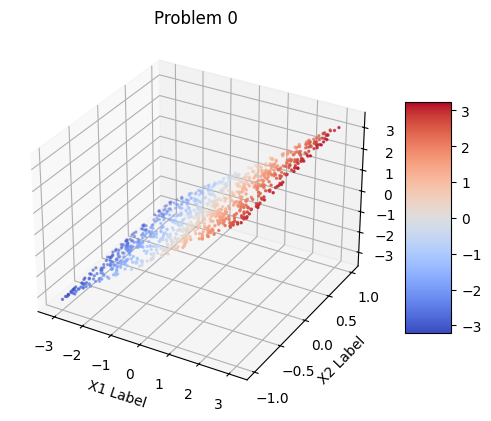

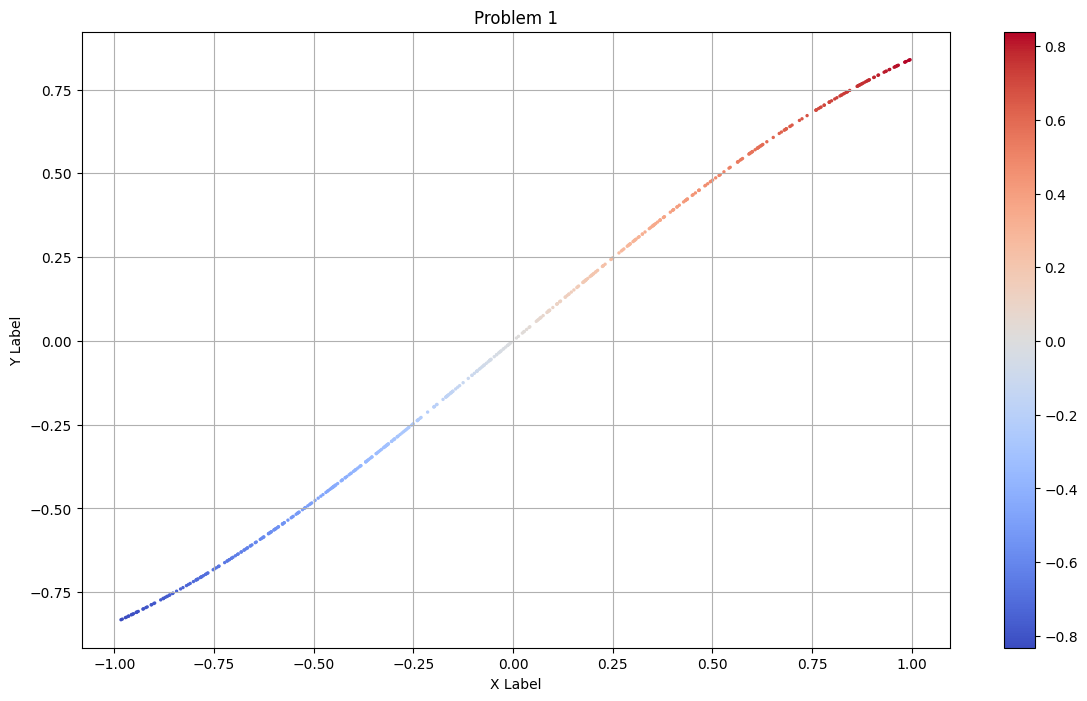

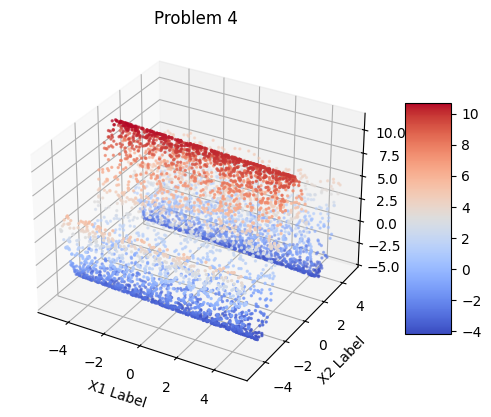

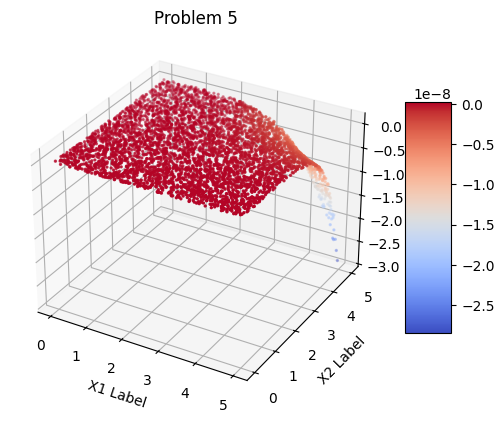

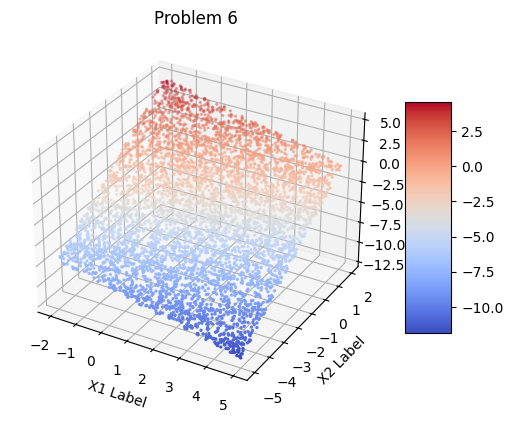

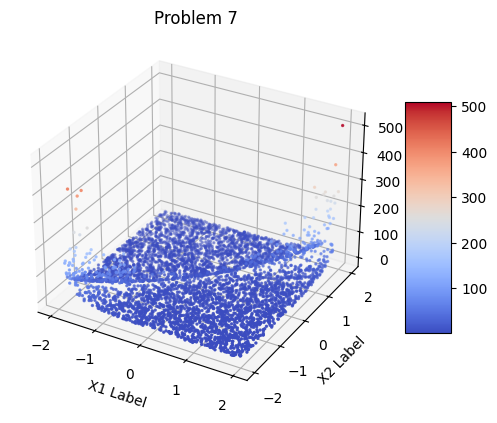

In [487]:
for p in range(0, 9):
    x = np.load(f"./data/problem_{p}.npz")

    dataset_dim = x['x'].shape[0]

    if dataset_dim == 1:
        plt.figure(figsize=(14,8))
        plt.xlabel('X Label')
        plt.ylabel('Y Label')
        plt.scatter(x['x'], x['y'], marker='o', s=2, c=x['y'], cmap="coolwarm")
        plt.title(f"Problem {p}")
        plt.grid()
        plt.colorbar()

    if dataset_dim == 2:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, projection='3d')

        # Assuming x_train has at least 3 dimensions for 3D plotting
        scatter = ax.scatter(x['x'][0], x['x'][1], x['y'], c=x['y'], marker='o', s=2, cmap="coolwarm")

        ax.set_xlabel('X1 Label')
        ax.set_ylabel('X2 Label')
        ax.set_zlabel('Y Label')
        ax.set_title(f"Problem {p}")
        fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)


plt.show()


## Setup
Setup of constants

In [488]:
# Env parameters
SEED = 42
TEST_SIZE = 0.1
NUM_FOLDS = 5
RED_FACTOR = 0.1
PROBLEM = 6

# Tree parameters
MAX_DEPTH = 10
NUM_CONSTANTS = 10
CONSTANTS_RANGE = 2

# Genetic Algorithm parameters
EXP_OPERATORS = False
BUCKET_SIZE = 3
OFFSPRING_SIZE = 30
POP_SIZE = 100
MAX_GENERATIONS = 10
MAX_STEADY = 40
MUTATION_PROB = 0.02
PENALTY_MAX = 0
PENALTY_MIN = 1e-6
REL_TOL_STEADY = 1e-3
PENALTY_STOP = MAX_GENERATIONS // 8
PENALTY = lambda g: (0.5 * (PENALTY_MAX - PENALTY_MIN) * (np.cos(np.pi * g / (PENALTY_STOP)) + 1) + PENALTY_MIN) if g < PENALTY_STOP else 0
PENALTY = lambda g: PENALTY_MAX

# Modality
class Modality(Enum):
    TRAIN = 0
    TEST_SINGLE_SPLIT = 1, TEST_SIZE
    TEST_K_FOLD = 2, NUM_FOLDS

MODE = Modality.TRAIN

## Helper functions

### Seed initialization for reproducibility

In [489]:
def init_rnd(seed):
    random.seed(seed)
    np.random.seed(seed)

### Random reduction of the dataset

In [490]:
def reduce_dataset(x, y, red_factor):

    if red_factor == 1:
        return x, y

    indices, _ = train_test_split(np.arange(x.shape[1]), train_size=red_factor)

    x_red = x[:, indices]
    y_red = y[indices]
    return x_red, y_red

### Parent selection
A random individual in a restricted bucket of best one is chosen.

In [491]:
def parent_selection(population: list[Individual]) -> Individual:
    candidates = sorted(np.random.choice(population, BUCKET_SIZE), key=lambda e: e.mse)
    return candidates[0]

### Mutation
The mutation is decided by the Tree class itself (same probability for point of subtree mutation)

In [492]:
def mutation(individual: Individual) -> Individual:
    new_individual = Individual(Tree.mutate(individual.genome), 0)
    return new_individual

### Crossover
Crossover is implemented by exchanging subtrees

In [493]:
def xover(parent1: Individual, parent2: Individual) -> Individual:
    offspring = Individual(Tree.crossover(parent1.genome, parent2.genome), 0)
    return offspring

### MSE plot functions

#### Linear scale

In [494]:
def plot_mse_gen(mses: list[list[float]], labels: list[str]):
    plt.figure()
    for i, mse in enumerate(mses):
        plt.plot(mse, label=labels[i])
    plt.legend()
    plt.title("MSE vs Generation")
    plt.xlabel("Generation")
    plt.ylabel("MSE")
    plt.grid()
    plt.show()

#### Log-linear scale

In [495]:
def plot_mse_gen_log(mses: list[list[float]], labels: list[str]):
    plt.figure()
    for i, mse in enumerate(mses):
        plt.semilogy(mse, label=labels[i])
    plt.legend()
    plt.title("MSE vs Generation")
    plt.xlabel("Generation")
    plt.ylabel("MSE")
    plt.grid()
    plt.show()

## Solve function
Evolutionary algorithm applied on trees.

In [496]:
def evolutionary_solve(
    population: list[Individual], 
    train_dataset: np.ndarray, 
    train_labels: np.ndarray, 
    mode: Modality, 
    val_dataset: np.ndarray = None, 
    val_labels: np.ndarray = None
) -> tuple[Individual, tuple[list[float], list[float]]]:

    for i in population:
        i.mse = float(Tree.mse(i.genome, train_dataset, train_labels, PENALTY(0)))

    mse_train = []
    champion_mse_train = []

    if mode != Modality.TRAIN:
        mse_val = []
    
    steady = 0
    restart_gen = 0
    for gen in tqdm(range(MAX_GENERATIONS)):
        offspring: list[Individual] = []
        for _ in range(OFFSPRING_SIZE):
            if np.random.random() < MUTATION_PROB:
                p = parent_selection(population)
                o = mutation(p)
            else:
                p1 = parent_selection(population)
                p2 = parent_selection(population)
                o = xover(p1, p2)

            offspring.append(o)

        for i in offspring:
            i.mse = float(Tree.mse(i.genome, train_dataset, train_labels, PENALTY(gen - restart_gen)))

        population.extend(offspring)

        # Survivor selection
        population.sort(key=lambda i: i.mse)
        population = population[:POP_SIZE]
        
        population = [p for p in population if p.mse != np.inf]
        
        # Data
        mean_depth = mean([i.genome.get_depth for i in population])
        mean_length = mean([len(i.genome) for i in population])

        # Statistics
        mse_gen = mean([i.mse for i in population])
        curr_champion_mse_train = population[0].mse
        mse_train.append(mse_gen)
        champion_mse_train.append(curr_champion_mse_train)
        
        curr_champion_mse = curr_champion_mse_train

        # Statistics logging
        if mode != Modality.TRAIN:
            mse_gen = mean([float(Tree.mse(i.genome, val_dataset, val_labels)) for i in population])
            mse_val.append(mse_gen)

            curr_champion_mse_val = float(Tree.mse(population[0].genome, val_dataset, val_labels))
            curr_champion_mse = curr_champion_mse_val
            
            print(f"Generation: {gen}, Champion - TR: {curr_champion_mse_train} ({mse_train[-1]}), Champion - VAL: {curr_champion_mse_val} ({mse_val[-1]}), Depth: {mean_depth:.3f}, Length: {mean_length:.3f}")
        else:
            print(f"Generation: {gen}, Champion - TR: {curr_champion_mse_train} ({mse_train[-1]}), Depth: {mean_depth:.3f}, Length: {mean_length:.3f}")

        #------- Logic for restarting
        
        # Check for steady state
        if gen > 0 and abs(curr_champion_mse - prev_champion_mse) / prev_champion_mse < REL_TOL_STEADY:
            steady += 1
        else:
            steady = 0

        # Check for restart
        if steady == MAX_STEADY:
            print("Restarting")
            
            # Elitism: only current champion survives 
            curr_champion = population[0]
            population = [Individual(Tree.create_individual(base_operators, curr_champion.genome.variables, curr_champion.genome.constants_bounds, MAX_DEPTH), 0) for _ in range(POP_SIZE-1)] + [curr_champion]
            
            for i in population[:-1]:
                i.mse = float(Tree.mse(i.genome, train_dataset, train_labels, PENALTY(0)))
            
            steady = 0
            restart_gen = gen
        
        prev_champion_mse = curr_champion_mse
        
    #-------- Plot losses (MSE)
    losses = None
    match mode:
        case Modality.TRAIN:
            plot_mse_gen_log([mse_train, champion_mse_train], ["Population", "Champion"])
            losses = mse_train, champion_mse_train
        case Modality.TEST_SINGLE_SPLIT:
            plot_mse_gen_log([mse_train, mse_val], ["Train", "Validation"])
            losses = mse_train, mse_val
        case Modality.TEST_K_FOLD:
            plot_mse_gen_log([mse_train, mse_val], ["Train", "Validation"])
            losses = mse_train, mse_val

    return population[0], losses

## Data acquisition

### Data reading 

In [497]:
x = np.load(f"./data/problem_{PROBLEM}.npz")
print(f"Solving problem {PROBLEM}")
x['x'].shape, x['y'].shape

Solving problem 6


((2, 5000), (5000,))

In [498]:
dataset_dim = x['x'].shape[0]
dataset_size = x['x'].shape[1]

### Data handling and splitting

In [505]:
# Training and validation done on the same dataset
if MODE == Modality.TRAIN:
    x_train, y_train = x['x'], x['y']
    x_val, y_val = None, None

# Single split cross-validation
elif MODE == Modality.TEST_SINGLE_SPLIT:
    train_indices, val_indices = train_test_split(range(dataset_size), test_size=TEST_SIZE, random_state=SEED)
    x_train, y_train = x['x'][:, train_indices], x['y'][train_indices]
    x_val, y_val = x['x'][:, val_indices], x['y'][val_indices]
    
# K-fold cross-validation
else:
    x_folds_train, y_folds_train = [], []
    x_folds_val, y_folds_val = [], []
    kf = KFold(n_splits=MODE.value[1], shuffle=True, random_state=SEED)
    for train_index, val_index in kf.split(x['x'].T):
        x_train, y_train = x['x'][:, train_index], x['y'][train_index]
        x_val, y_val = x['x'][:, val_index], x['y'][val_index]

        x_folds_train.append(x_train)
        y_folds_train.append(y_train)
        x_folds_val.append(x_val)
        y_folds_val.append(y_val)

## Problem solution

Solving problem 6
(2, 500) (500,)


  0%|          | 0/10 [00:00<?, ?it/s]

Generation: 0, Champion - TR: 265.6583710548158 (2596.7620711664763), Depth: 4.530, Length: 9.900
Generation: 1, Champion - TR: 265.6583710548158 (2207.762730760878), Depth: 4.520, Length: 10.860
Generation: 2, Champion - TR: 265.6583710548158 (1936.2462731782387), Depth: 4.330, Length: 11.090
Generation: 3, Champion - TR: 234.7960832873252 (1743.909685599037), Depth: 4.420, Length: 11.870
Generation: 4, Champion - TR: 234.7960832873252 (1416.5049981920029), Depth: 4.550, Length: 13.000
Generation: 5, Champion - TR: 234.7960832873252 (1167.6575052509127), Depth: 4.850, Length: 14.520
Generation: 6, Champion - TR: 230.24723283066112 (931.2144028598325), Depth: 4.850, Length: 15.110
Generation: 7, Champion - TR: 229.84454328806424 (689.3918481186541), Depth: 5.350, Length: 17.640
Generation: 8, Champion - TR: 158.6014969183279 (509.9480070470934), Depth: 5.710, Length: 20.300
Generation: 9, Champion - TR: 158.6014969183279 (396.5308234030098), Depth: 5.990, Length: 21.320


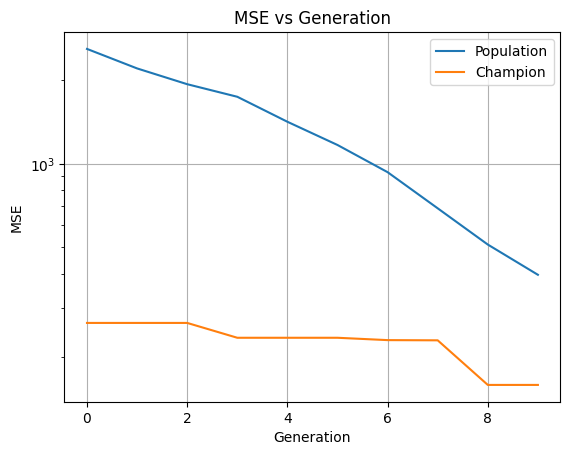

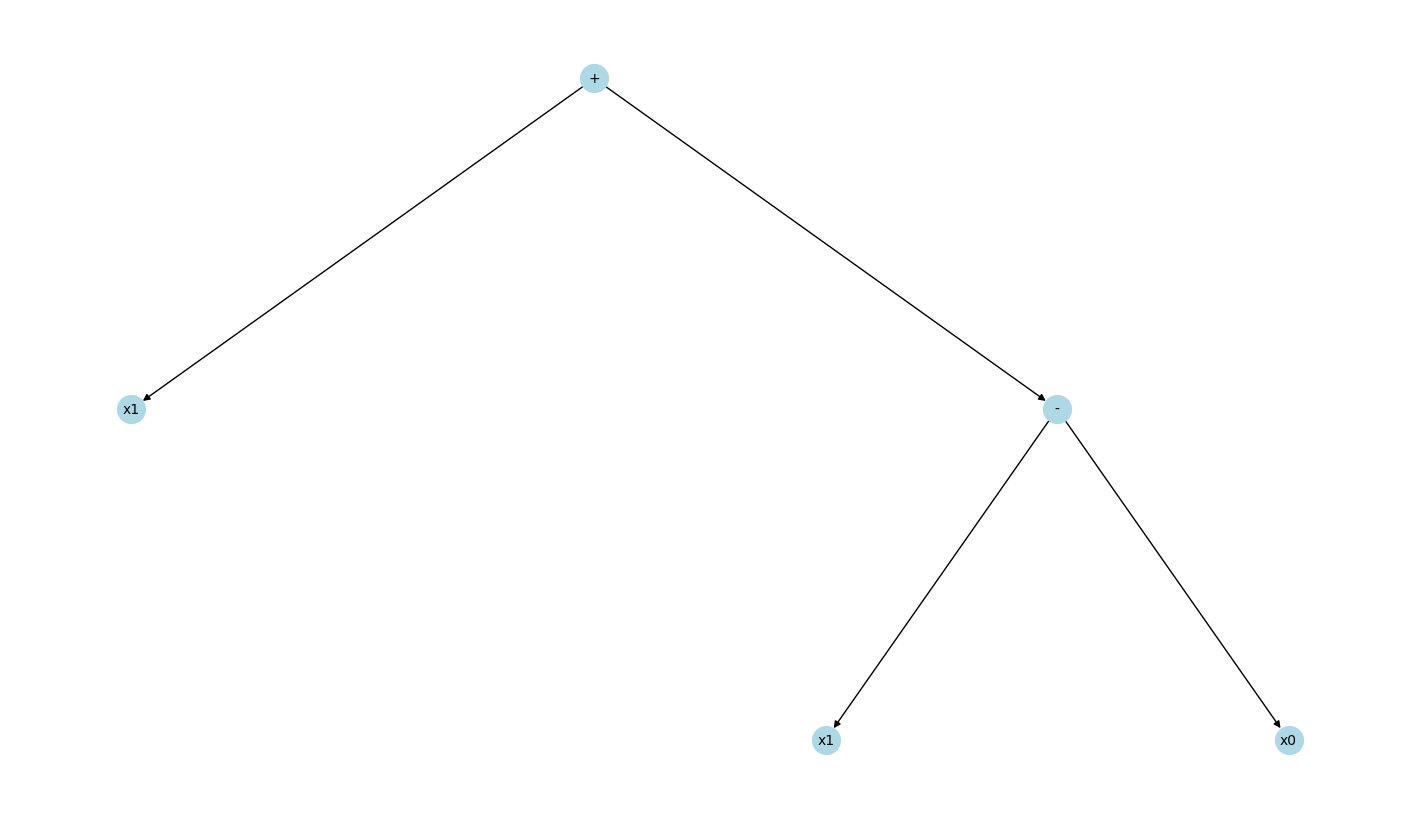

Overall MSE: 159.97201539346332
Formula: (x[1] + (x[1] - x[0]))


In [506]:
# Initialize random seed
init_rnd(SEED)

# Initialize population
variables = [f"x{i}" for i in range(dataset_dim)]
operators = base_operators if not EXP_OPERATORS else base_operators + exp_operators
constants_bounds = (-CONSTANTS_RANGE, CONSTANTS_RANGE)
population = [Individual(Tree.create_individual(base_operators, variables, constants_bounds, max_depth=MAX_DEPTH), 0) for _ in range(POP_SIZE)]

print(f"Solving problem {PROBLEM}")

# Reduce dataset (only in training mode)
x_total, y_total = x_train, y_train
if RED_FACTOR != 1 and MODE == Modality.TRAIN:
    x_train, y_train = reduce_dataset(x_train, y_train, RED_FACTOR)

# Print dataset shapes
print(x_train.shape, y_train.shape)
if MODE != Modality.TRAIN:
    print(x_val.shape, y_val.shape)

#----------- Solve problem

# Training mode: all data retained is used for both training and validation 
if MODE == Modality.TRAIN:
    champion, (train_losses, champ_losses) = evolutionary_solve(population, x_train, y_train, MODE)

# Single-split validation mode: data is split into training and validation sets
# The champion is evaluated on the validation set
# More consistent, but issues due to smaller dataset
elif MODE == Modality.TEST_SINGLE_SPLIT:
    champion, (train_losses, val_losses) = evolutionary_solve(population, x_train, y_train, MODE, x_val, y_val)
    
# K-fold cross-validation mode: data is split into k folds
# The champion is evaluated on each fold and the final champion is the average of the k champions
# More robust, but issues due to smaller datasets
# Very time-consuming
# Not used in final experiments, but the code has been run for testing purposes
else:
    champions: list[Individual] = []
    train_losses, val_losses = [], []
    
    # Iterate over the folds
    for x_train, y_train, x_val, y_val in zip(x_folds_train, y_folds_train, x_folds_val, y_folds_val):
        
        # Find and evaluate the champion for each fold
        champion, (train_losses_single, val_losses_single) = evolutionary_solve(population, x_train, y_train, MODE, x_val, y_val)
        champions.append(champion)
        train_losses.append(train_losses_single)
        val_losses.append(val_losses_single)

    # Merge the champions into a single champion
    # Evaluation is done later
    champion_genome = Tree.merge([ch.genome for ch in champions])
    champion = Individual(champion_genome, 0)
    
# Plot the champion genome (formula)
champion.genome.draw()
plt.show()

# Evaluate the champion on the total dataset (even if reduced for training)
mse_overall = Tree.mse(champion.genome, x_total, y_total)

# Plot results
# In case of single-split validation, the validation MSE is also computed
if MODE == Modality.TEST_SINGLE_SPLIT:
    mse_val = Tree.mse(champion.genome, x_val, y_val)
    print(f"Train MSE: {champion.mse}, Validation MSE: {mse_val}, Overall MSE: {mse_overall}")
else:
    print(f"Overall MSE: {mse_overall}")


# Plot the champion formula as mathematical notation
print(f"Formula: {champion.genome}")